# Calculate the feedbacks in single model abrupt-4xCO2 experiment by using the radiatvie kernel 

>ref: [Soden, et.al., (2008)](https://doi.org/10.1175/2007JCLI2110.1)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import subprocess 
import time
from scipy import stats
sstart_time0 = time.time()

In [2]:
# # download r3k functions on the fly from github
# # comment this line if you manually downloaded it
# ! wget https://raw.githubusercontent.com/ChenggongWang/Radiative_Response_with_Radiative_Kernel/main/Radiative_Repsonse_with_Raditive_kernel.py -O Radiative_Repsonse_with_Raditive_kernel.py

In [3]:
# import the function as r3k 
import Radiative_Repsonse_with_Raditive_kernel as r3k
r3k.compile_njit_functions()

@njit Functions compiling ...  | finished!


# Data required and preprocess


- 8 Month mean variables [CMIP6 standard output](https://pcmdi.llnl.gov/mips/cmip3/variableList.html): 
`ta, hus, ts, rlut, rsdt, rsut, rsutcs, rlutcs`

- Control (12 month climatology) and Perturbation (nx12 monthly data) data are need.
If you have already computed anormaly data, create a control data filled with zeros
- `ta` and `hus` are 4d `(time, plev, lat, lon)` variables, while others are 3d `(time, lat, lon)` variables.
`time` should be nx12 month (n years >= 1 year). 

- __Since data and kernel are discrete, we need regrid them to the same resolution.__
My practice: bring(regrid) the data to kernels.

### __Download example data (4GB)__

> from: https://drive.google.com/drive/folders/1wtsZ4-kRXmNe2MXb2-czs4osTKASGa0x?usp=sharing
>
> or: https://tigress-web.princeton.edu/~cw55/share_data/r3k_example_data.tar (extract files: tar -xf xxx.tar)
>
> make sure data and kernel in path: ./data/

>1. GFDL kernel file
>2. GFDL-CM4 piControl
>3. 4xCO2 experiment


In [4]:

def read_postprocessed_data_example():
    """
    This function read and process example data.
    Please create your own function for your data.
    The required variables are: ta hus ts rlut rsdt rsut rlutcs rsutcs rsus rsds, which in CMIP6 standard name (ref: https://pcmdi.llnl.gov/mips/cmip3/variableList.html#overview)

    Return:
        var_cont: dict of variables (monthly climatology of the control experiment. dim: [month,plev,lat,lon], month.size=12)
        var_pert: dict of variables (monthly data of the perturbation experiment. dim: [time,plev,lat,lon], time.size=yearx12) 
    """
    # CMIP6 standard name, 
    # ref: https://pcmdi.llnl.gov/mips/cmip3/variableList.html#overview
    var_list = 'ta hus ts rlut rsdt rsut rlutcs rsutcs rsus rsds'.split()
    # control data in a dictionary {var1: DataArray,...} 
    var_cont = {}
    for var in var_list:
        filepath = f"./data/piControl/GFDL-CM4/{var}.mon.0001-0200.ltm.nc.r1i1p1f1.2x2.5.2021052021"
        var_cont[var] =  xr.open_dataset(filepath)[var].isel(model=0).load() # load into memory
    # perturbation data in a dictionary {var1: DataArray,...} 
    var_pert = {}
    for var in var_list:
        filepath = f"./data/abrupt-4xCO2/GFDL-CM4/{var}.mon.0001-0150.nc.r1i1p1f1.2x2.5.2021052021"
        var_pert[var] =  xr.open_dataset(filepath)[var].isel(model=0).load() # load into memory
    # return processed data 
    return var_cont, var_pert

# read kernel data
def read_kernel_file(rk_source='GFDL'):
    rkpath = "./data/kernels_TOA_"+rk_source+"_CMIP6-standard.nc"
    f_RK =  xr.open_dataset(rkpath,decode_times=False) 
    if rk_source =='GFDL':
        f_RK =  f_RK.rename({'time': 'month'})
        f_RK.coords['month'] = np.arange(1,13,1)
    return f_RK

In [5]:
%%time
# read data
f_RK =  read_kernel_file()
var_cont, var_pert = read_postprocessed_data_example()

CPU times: user 339 ms, sys: 1.67 s, total: 2.01 s
Wall time: 6.07 s


In [6]:
# %%time
# compute RR with RK
ds_rk =  r3k.decompose_dR_rk_toa_core(var_pert,var_cont,f_RK )

# Plot Results (decomposed radiative response) in time series

## rh decomposition

In [17]:
dR_temp_gm = (ds_rk['dR_Ta_rh_lw_gm'] + ds_rk['dR_Ta_rh_sw_gm'] + ds_rk['dR_ts_gm']).groupby('time.year').mean('time')
dR_lr_gm   = (ds_rk['dR_LR_rh_lw_gm'] + ds_rk['dR_LR_rh_sw_gm']  ).groupby('time.year').mean('time')
dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
dR_wv_gm   = (ds_rk['dR_rh_lw_gm']     + ds_rk['dR_rh_sw_gm']    ).groupby('time.year').mean('time')
dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')

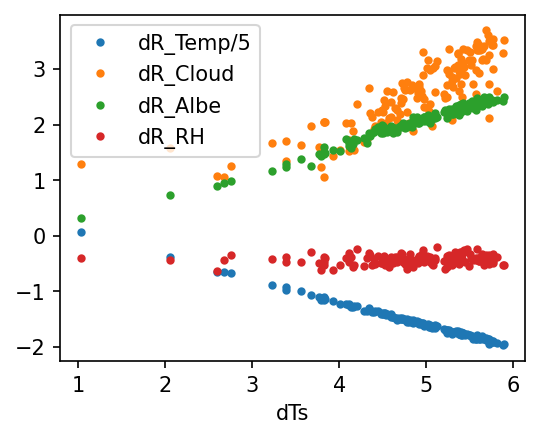

In [18]:
plt.close()
fig0 = plt.figure(figsize=(4,3),dpi=150)
ax1   = fig0.add_subplot(111)
ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albe')
ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_RH')
ax1.set_xlabel('dTs')
plt.legend()
plt.show()

calculate climate feedbacks 

regress the RR on to ts and the slope is the climate feedback

In [20]:
fb_name = ['Plank', 'LR', 'Cloud','RH','Alb']
dR_list = {
    'Plank':dR_temp_gm-dR_lr_gm,
    'LR':dR_lr_gm,
    'Cloud': dR_clou_gm,
    'RH':dR_wv_gm,
    'Alb':dR_albe_gm
}
for name in fb_name:
    fb = stats.linregress(dts_gm, dR_list[name]).slope
    print(f'{name:6s}:{fb:5.2f} W/m2/K')

Plank :-2.21 W/m2/K
LR    : 0.19 W/m2/K
Cloud : 0.67 W/m2/K
RH    : 0.02 W/m2/K
Alb   : 0.48 W/m2/K


## Conventional decomposition

In [13]:
dR_temp_gm = (ds_rk['dR_ta_gm']        + ds_rk['dR_ts_gm']       ).groupby('time.year').mean('time')
dR_lr_gm   = ds_rk['dR_lr_gm'].groupby('time.year').mean('time')
dR_clou_gm = (ds_rk['dR_cloud_lw_gm']  + ds_rk['dR_cloud_sw_gm'] ).groupby('time.year').mean('time')
dR_wv_gm   = (ds_rk['dR_wv_lw_gm']     + ds_rk['dR_wv_sw_gm']    ).groupby('time.year').mean('time')
dR_albe_gm = ds_rk['dR_alb_gm'].groupby('time.year').mean('time')
dts_gm     = ds_rk['dts_gm']   .groupby('time.year').mean('time')

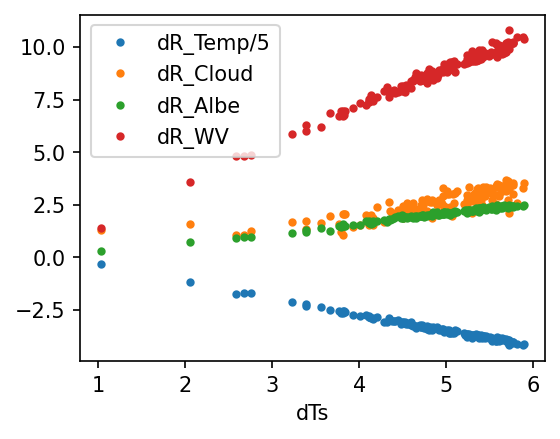

In [14]:
plt.close()
fig0 = plt.figure(figsize=(4,3),dpi=150)
ax1   = fig0.add_subplot(111)
ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albe')
ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_WV')
ax1.set_xlabel('dTs')
plt.legend()
plt.show()

calculate climate feedbacks 

regress the RR on to ts and the slope is the climate feedback

In [16]:
fb_name = ['Plank','LR','Cloud','WV','Alb']
dR_list = {
    'Plank':dR_temp_gm-dR_lr_gm,
    'LR':dR_lr_gm,
    'Cloud': dR_clou_gm,
    'WV':dR_wv_gm,
    'Alb':dR_albe_gm
}
for name in fb_name:
    
    fb = stats.linregress(dts_gm, dR_list[name]).slope
    print(f'{name:6s}:{fb:5.2f} W/m2/K')

Plank :-3.55 W/m2/K
LR    :-0.20 W/m2/K
Cloud : 0.67 W/m2/K
WV    : 1.74 W/m2/K
Alb   : 0.48 W/m2/K
